# **Box Plots**


-   Visualize the distribution of data.

-   Visualize the relationship between two features.

-   Visualize data composition and comparisons using box plots.


###  Connecting to the Database


#### 1. Download the Database File


In [1]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite

--2025-06-11 21:24:42--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
200 OKequest sent, awaiting response... 
Length: 211415040 (202M) [application/octet-stream]
Saving to: ‘survey-results-public.sqlite.1’

survey-results-publ 100%[===================>] 201.62M  57.6MB/s    in 3.5s    

2025-06-11 21:24:49 (57.7 MB/s) - ‘survey-results-public.sqlite.1’ saved [211415040/211415040]



#### 2. Connect to the Database


**Install the needed libraries**


In [2]:
!pip install pandas

In [3]:
!pip install matplotlib
!pip install seaborn

In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect('survey-results-public.sqlite')


## Basic SQL Queries


#### Count the Number of Rows in the Table


In [5]:
QUERY = "SELECT COUNT(*) FROM main"
df = pd.read_sql_query(QUERY, conn)
print(df)


   COUNT(*)
0     65437


#### List All Tables


In [6]:
QUERY = """
SELECT name as Table_Name 
FROM sqlite_master 
WHERE type = 'table'
"""
pd.read_sql_query(QUERY, conn)


,Table_Name
0,main


####  Group Data by Age


In [7]:
QUERY = """
SELECT Age, COUNT(*) as count 
FROM main 
GROUP BY Age 
ORDER BY Age
"""
df_age = pd.read_sql_query(QUERY, conn)
print(df_age)


                  Age  count
0     18-24 years old  14098
1     25-34 years old  23911
2     35-44 years old  14942
3     45-54 years old   6249
4     55-64 years old   2575
5   65 years or older    772
6   Prefer not to say    322
7  Under 18 years old   2568


## Visualizing Data


### Task 1: Visualizing the Distribution of Data


**1. Box Plot of `CompTotal` (Total Compensation)**


Use a box plot to analyze the distribution and outliers in total compensation.


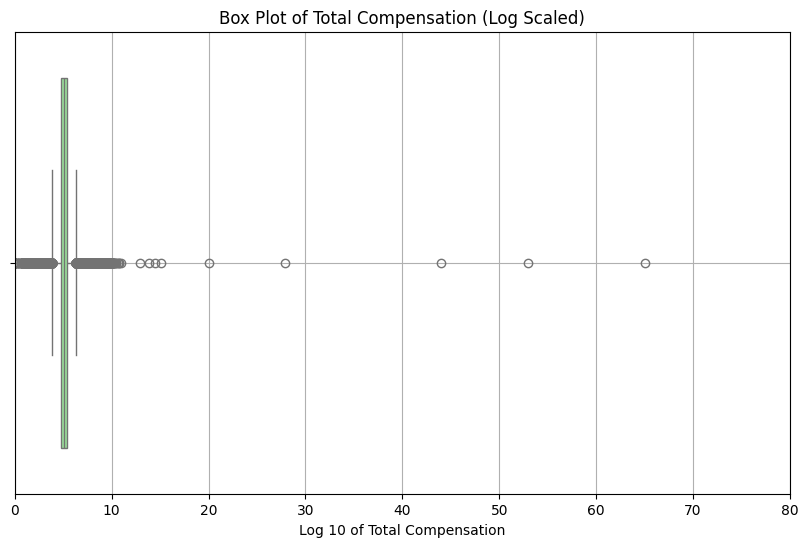

In [8]:
query = """
SELECT CompTotal
FROM main
WHERE CompTotal IS NOT NULL AND CompTotal > 0
"""
df = pd.read_sql_query(query, conn)
import numpy as np
#apply a log scale if compensation values vary greatly
df['LogCompTotal'] = np.log10(df['CompTotal'])

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['LogCompTotal'], color='lightgreen')

plt.xlabel('Log 10 of Total Compensation')
plt.title('Box Plot of Total Compensation (Log Scaled)')
plt.grid(True)
plt.xlim(0,80)
plt.show()

**2. Box Plot of Age (converted to numeric values)**


Convert the `Age` column into numerical values and visualize the distribution.


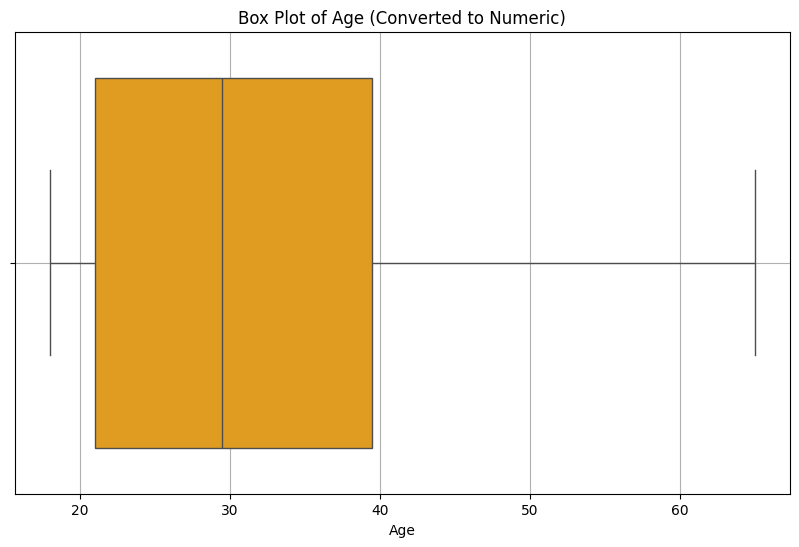

In [9]:
QUERY = """
SELECT * FROM main
"""

df1 = pd.read_sql_query(QUERY, conn)
import numpy as np
# Map the age to midpoint of range
age_mapping = {'Under 18 years old': 18,
               '18-24 years old': (18+24)/2,
               '25-34 years old': (25+34)/2,
               '35-44 years old': (35+44)/2,
               '45-54 years old': (45+54)/2,
               '55-64 years old': (55+64)/2,
               '65 years or older': 65,
               }

df1["Age_mapped"] = df1["Age"].map(age_mapping)

# Drop NULL values
df1 = df1.dropna(subset=['Age_mapped'])
df1['Age_mapped'] = pd.to_numeric(df1['Age_mapped'], errors='coerce')
# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df1['Age_mapped'], color='orange')

plt.xlabel('Age')
plt.title('Box Plot of Age (Converted to Numeric)')
plt.grid(True)
plt.show()


### Task 2: Visualizing Relationships in Data


**1. Box Plot of `CompTotal` Grouped by Age Groups:**


Visualize the distribution of compensation across different age groups.


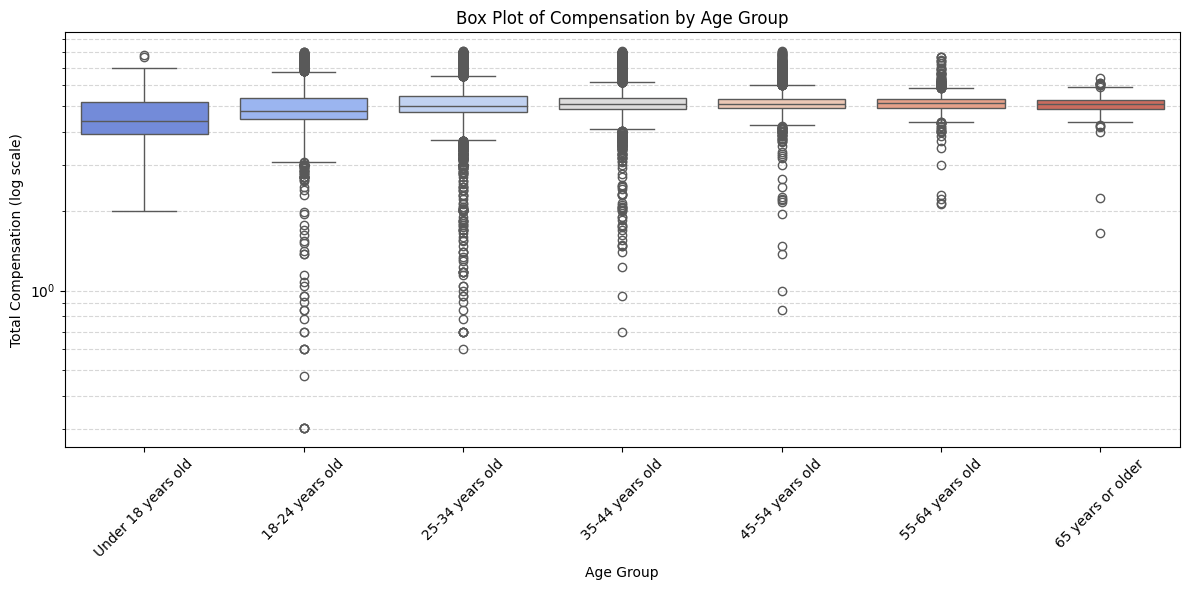

In [10]:
# Step 1: Query data
df1 = pd.read_sql_query("""
    SELECT CompTotal, Age 
    FROM main
""", conn)
import numpy as np
# Step 3: Define age group order
age_order = [
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older'
]

# Step 4: Convert Age to categorical for ordered box plot
df1['Age'] = pd.Categorical(df1['Age'], categories=age_order, ordered=True)

# Convert compensation column to numeric
df1['CompTotal'] = pd.to_numeric(df1['CompTotal'], errors='coerce')
 #Filter out invalid compensation values
df1 = df1[df1['CompTotal'] > 0]

#Remove extreme outliers (top 1% compensation)
comp_threshold = df1['CompTotal'].quantile(0.99)
df1 = df1[df1['CompTotal'] <= comp_threshold]
# Drop rows where Age_mapped is still NaN after conversion
df1 = df1.dropna(subset=['Age','CompTotal'])
#apply a log scale if compensation values vary greatly
df1['LogCompTotal'] = np.log10(df1['CompTotal'])


# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='LogCompTotal',hue='Age', data=df1, palette='coolwarm')

plt.yscale('log')  # Use log scale due to wide compensation range
plt.xlabel('Age Group')
plt.ylabel('Total Compensation (log scale)')
plt.title('Box Plot of Compensation by Age Group')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**2. Box Plot of `CompTotal` Grouped by Job Satisfaction (`JobSatPoints_6`):**


Examine how compensation varies based on job satisfaction levels.


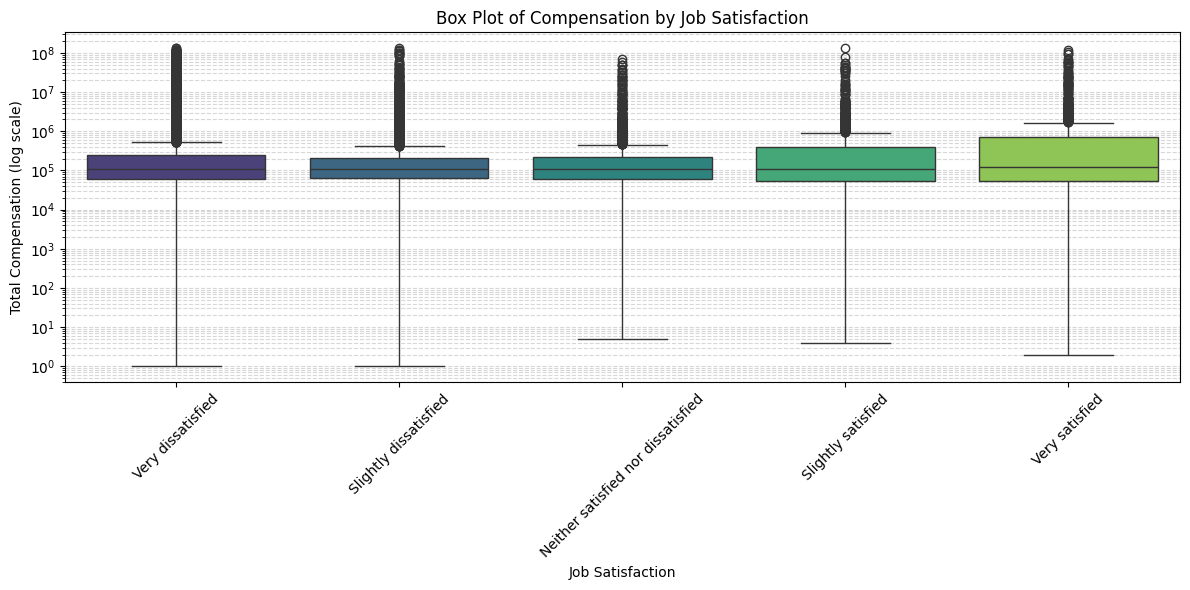

In [11]:
# Step 1: Query data
df1 = pd.read_sql_query("""
    SELECT CompTotal, JobSatPoints_6
    FROM main
""", conn)


# Convert compensation column to numeric
df1['CompTotal'] = pd.to_numeric(df1['CompTotal'], errors='coerce')
df1['JobSatPoints_6'] = pd.to_numeric(df1['JobSatPoints_6'], errors='coerce')
# Drop rows where Age_mapped is still NaN after conversion
df1 = df1.dropna(subset=['CompTotal','JobSatPoints_6'])
#  Filter out invalid compensation values
df1 = df1[df1['CompTotal'] > 0]

# Remove extreme outliers (top 1% compensation)
comp_threshold = df1['CompTotal'].quantile(0.99)
df1 = df1[df1['CompTotal'] <= comp_threshold]
# Define bins and labels
bins = [0, 20, 40, 60, 80, 100]  # ranges for each category
labels = [
    'Very dissatisfied',
    'Slightly dissatisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly satisfied',
    'Very satisfied'
]


df1['JobSat_bins'] = pd.cut(df1['JobSatPoints_6'], bins=bins, labels=labels, right=True, include_lowest=True)

# Convert to ordered categorical dtype for plotting in correct order
df1['JobSat_bins'] = pd.Categorical(df1['JobSat_bins'], categories=labels, ordered=True)


# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='JobSat_bins', y='CompTotal',hue='JobSat_bins', data=df1, palette='viridis')

plt.yscale('log')  # Use log scale due to wide compensation range
plt.xlabel('Job Satisfaction')
plt.ylabel('Total Compensation (log scale)')
plt.title('Box Plot of Compensation by Job Satisfaction')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Task 3: Visualizing the Composition of Data


**1. Box Plot of `ConvertedCompYearly` for the Top 5 Developer Types:**


Analyze compensation across the top 5 developer roles.


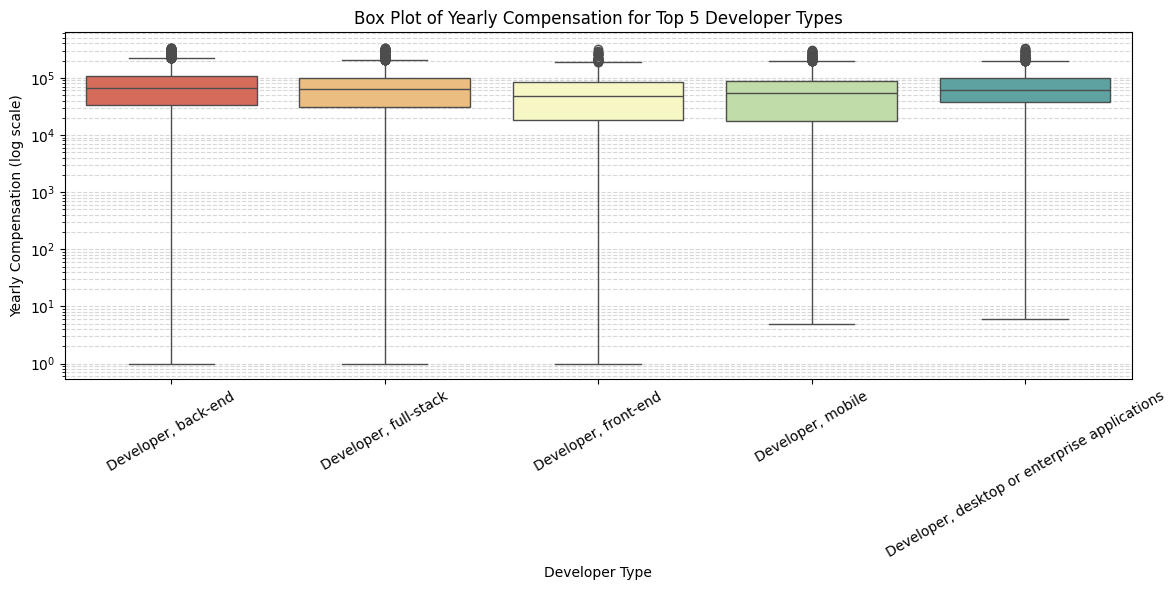

In [32]:
# Step 1: Query relevant columns
df = pd.read_sql_query("""
    SELECT DevType, ConvertedCompYearly
    FROM main
""", conn)

# Step 2: Drop missing or invalid compensation values
df['ConvertedCompYearly'] = pd.to_numeric(df['ConvertedCompYearly'], errors='coerce')
df = df.dropna(subset=['ConvertedCompYearly', 'DevType'])
df = df[df['ConvertedCompYearly'] > 0]

# Step 3: Explode DevType into separate rows
df_exploded = df.assign(DevType=df['DevType'].str.split(';')).explode('DevType')
df_exploded['DevType'] = df_exploded['DevType'].str.strip()

# Step 4: Get top 5 DevType role names by frequency
top_roles = df_exploded['DevType'].value_counts().nlargest(5).index.tolist()
# Step 5: Filter data for top 5 roles
df_top_roles = df_exploded[df_exploded['DevType'].isin(top_roles)]


# Step 6: Remove top 1% compensation outliers
comp_threshold = df_top_roles['ConvertedCompYearly'].quantile(0.99)
df_top_roles = df_top_roles[df_top_roles['ConvertedCompYearly'] <= comp_threshold]

# Step 7: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_roles, x='DevType', y='ConvertedCompYearly', hue='DevType', palette='Spectral')
plt.yscale('log')  # Log scale to handle wide range of values
plt.title('Box Plot of Yearly Compensation for Top 5 Developer Types')
plt.xlabel('Developer Type')
plt.ylabel('Yearly Compensation (log scale)')
plt.xticks(rotation=30)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**2. Box Plot of `CompTotal` for the Top 5 Countries:**


Analyze compensation across respondents from the top 5 countries.


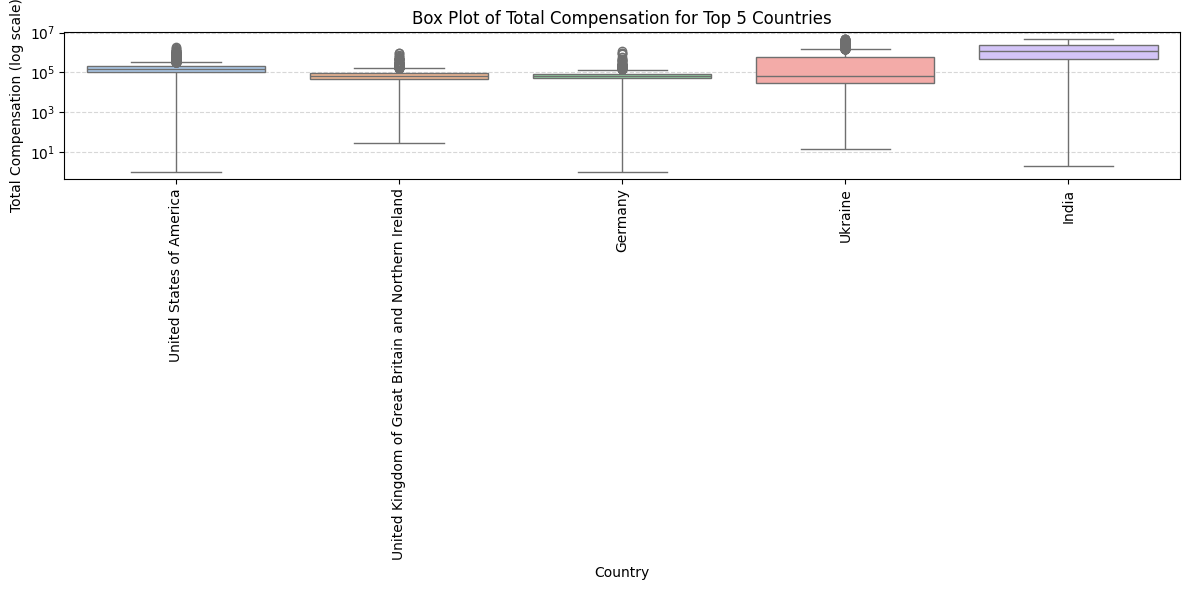

In [23]:
# Step 1: Query relevant data
df = pd.read_sql_query("""
    SELECT Country, CompTotal
    FROM main
""", conn)

# Step 2: Clean and convert
df['CompTotal'] = pd.to_numeric(df['CompTotal'], errors='coerce')
df = df.dropna(subset=['CompTotal', 'Country'])
df = df[df['CompTotal'] > 0]

# Step 3: Identify top 5 countries by frequency
top_countries = df['Country'].value_counts().nlargest(5).index.tolist()

# Step 4: Filter dataset to only those top 5 countries
df_top = df[df['Country'].isin(top_countries)]

# Step 5: Remove top 1% compensation outliers
comp_threshold = df_top['CompTotal'].quantile(0.99)
df_top = df_top[df_top['CompTotal'] <= comp_threshold]

# Step 6: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top, x='Country', y='CompTotal', hue='Country', palette='pastel')
plt.yscale('log')  # Log scale for compensation
plt.title('Box Plot of Total Compensation for Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Total Compensation (log scale)')
plt.xticks(rotation=90)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Task 4: Visualizing Comparison of Data


**1. Box Plot of CompTotal Across Employment Types:**


Analyze compensation for different employment types.


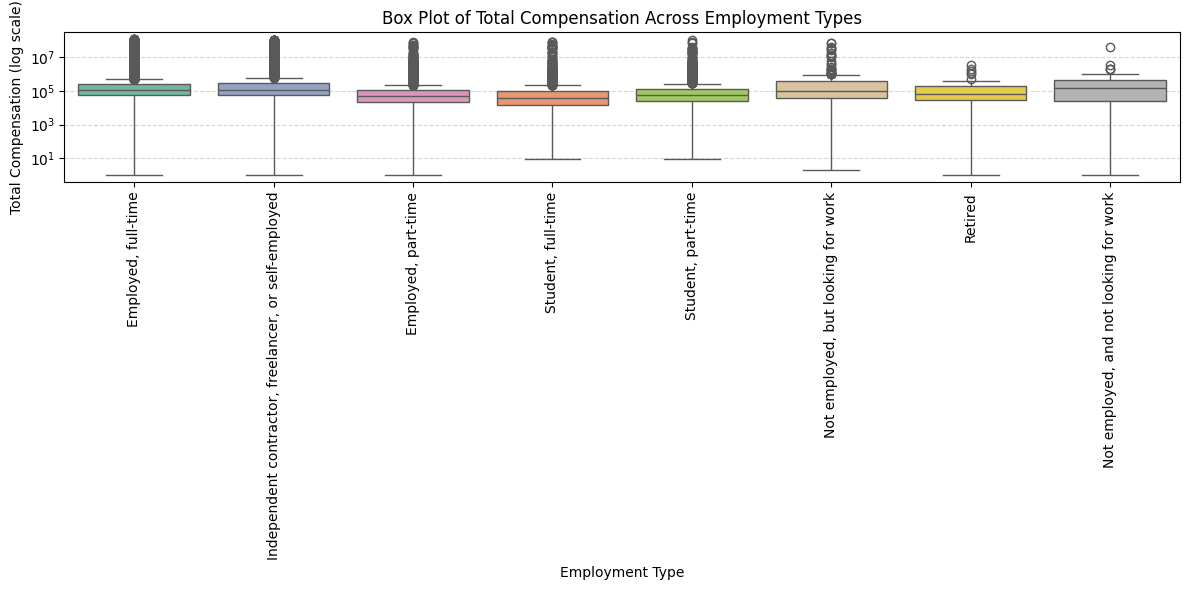

In [25]:
# Step 1: Query relevant data
df = pd.read_sql_query("""
    SELECT Employment, CompTotal
    FROM main
""", conn)

# Step 2: Clean data
df['CompTotal'] = pd.to_numeric(df['CompTotal'], errors='coerce')
df = df.dropna(subset=['CompTotal', 'Employment'])
df = df[df['CompTotal'] > 0]

# Step 3: Remove top 1% of compensation values (extreme outliers)
comp_threshold = df['CompTotal'].quantile(0.99)
df = df[df['CompTotal'] <= comp_threshold]
# Step 4: Split and explode employment types
df['Employment'] = df['Employment'].str.split(';')
df = df.explode('Employment')
df['Employment'] = df['Employment'].str.strip()  # remove extra spaces


# Order employment types by frequency
employment_order = df['Employment'].value_counts().index.tolist()

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Employment', y='CompTotal', hue='Employment',order=employment_order, palette='Set2')
plt.yscale('log')  # Log scale for wide comp range
plt.title('Box Plot of Total Compensation Across Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Total Compensation (log scale)')
plt.xticks(rotation=90)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**2. Box Plot of `YearsCodePro` by Job Satisfaction (`JobSatPoints_6`):**


Examine the distribution of professional coding years by job satisfaction levels.


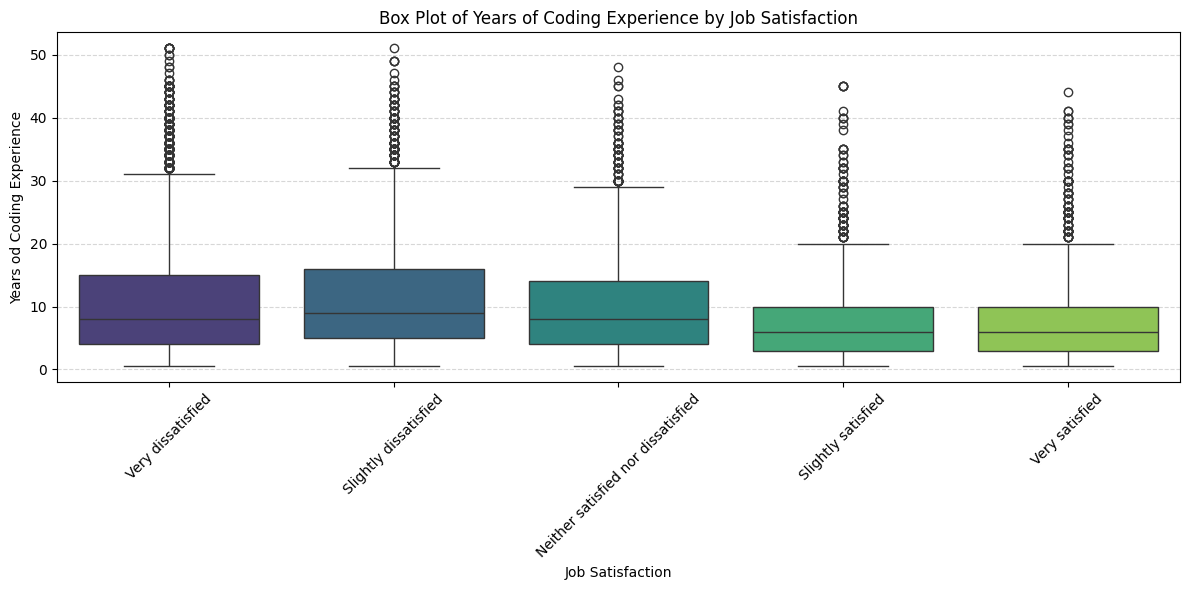

In [28]:
# Step 1: Query data
df1 = pd.read_sql_query("""
    SELECT YearsCodePro, JobSatPoints_6
    FROM main
""", conn)
# Convert YearsCodePro to numeric (handle 'Less than 1 year' and 'More than 50 years')
df1['YearsCodePro'] = df1['YearsCodePro'].replace({
    'Less than 1 year': '0.5',
    'More than 50 years': '51'
})

# Convert compensation column to numeric
df1['YearsCodePro'] = pd.to_numeric(df1['YearsCodePro'], errors='coerce')
df1['JobSatPoints_6'] = pd.to_numeric(df1['JobSatPoints_6'], errors='coerce')
# Drop rows where Age_mapped is still NaN after conversion
df1 = df1.dropna(subset=['YearsCodePro','JobSatPoints_6'])
#  Filter out invalid compensation values
df1 = df1[df1['YearsCodePro'] > 0]


# Define bins and labels
bins = [0, 20, 40, 60, 80, 100]  # ranges for each category
labels = [
    'Very dissatisfied',
    'Slightly dissatisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly satisfied',
    'Very satisfied'
]

df1['JobSat_bins'] = pd.cut(df1['JobSatPoints_6'], bins=bins, labels=labels, right=True, include_lowest=True)

# Convert to ordered categorical dtype for plotting in correct order
df1['JobSat_bins'] = pd.Categorical(df1['JobSat_bins'], categories=labels, ordered=True)


# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='JobSat_bins', y='YearsCodePro',hue='JobSat_bins', data=df1, palette='viridis')


plt.xlabel('Job Satisfaction')
plt.ylabel('Years od Coding Experience')
plt.title('Box Plot of Years of Coding Experience by Job Satisfaction')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Final Step: Close the Database Connection


After completing the lab, close the connection to the SQLite database:


In [33]:
conn.close()